## CV Final Project: Interest Point Detector + Descriptor using SURF
Aja Klevs + Micaela Flores

In [78]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import time
import scipy
from PIL import Image
import math
import scipy.misc
from scipy.ndimage.interpolation import zoom

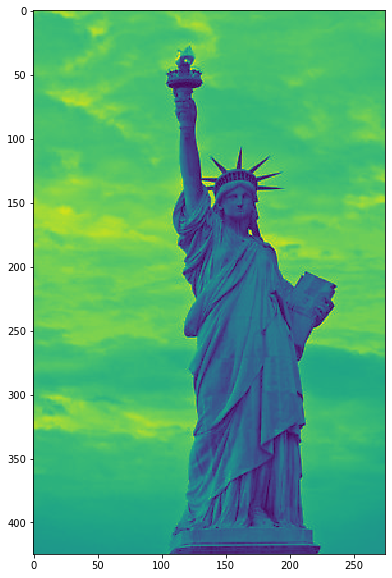

In [74]:

lady = plt.imread('lady_liberty1.jpeg')
lady = lady[25:450, 25:300]
plt.figure(figsize=((15,10)))
plt.imshow(lady)
plt.show()

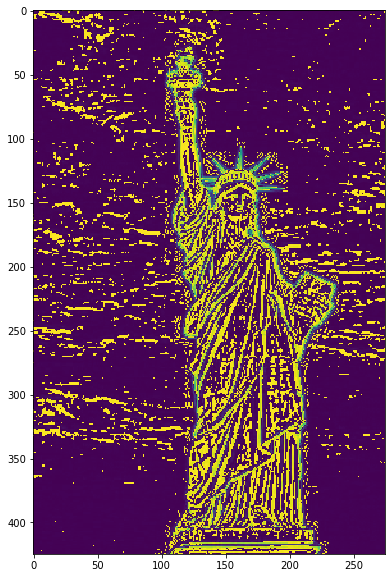

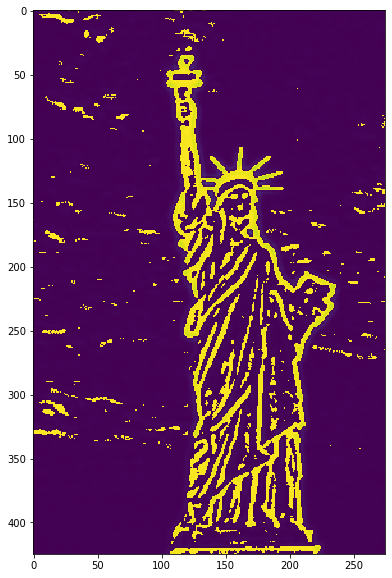

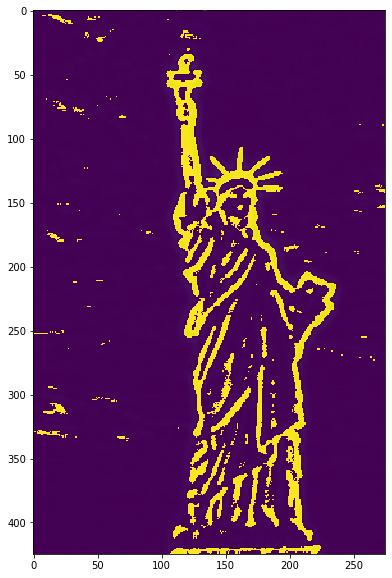

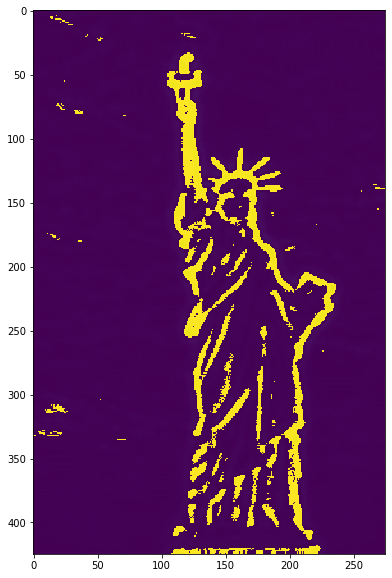

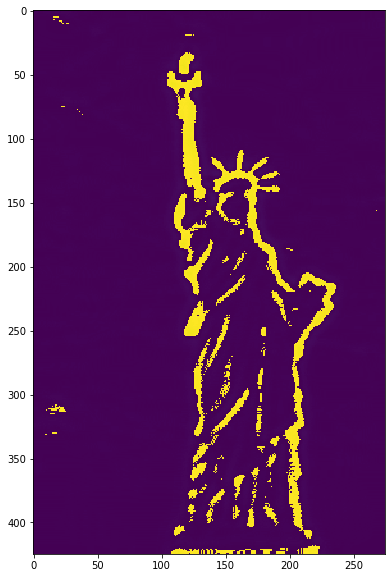

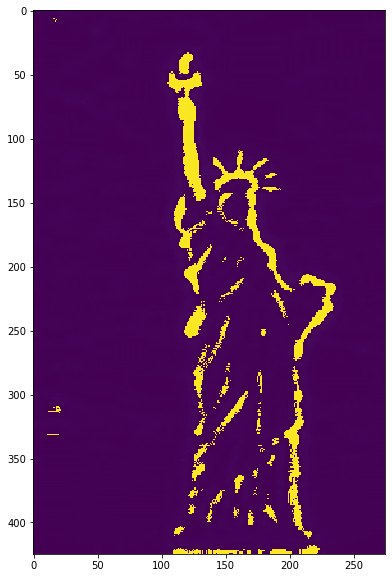

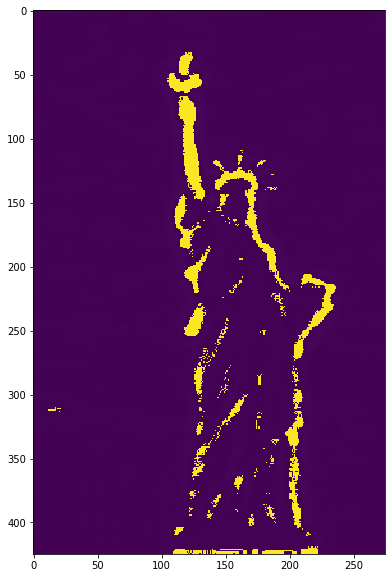

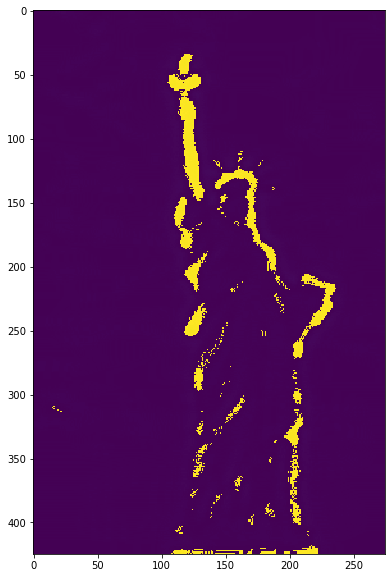

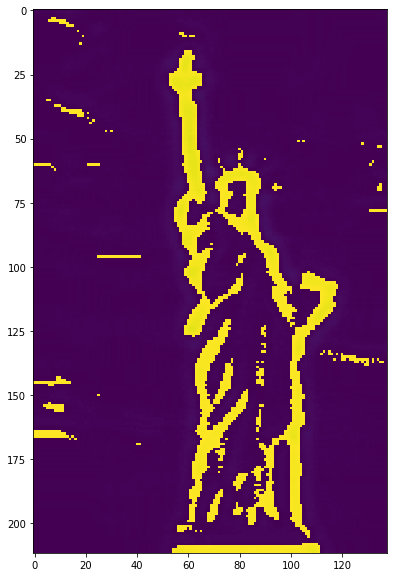

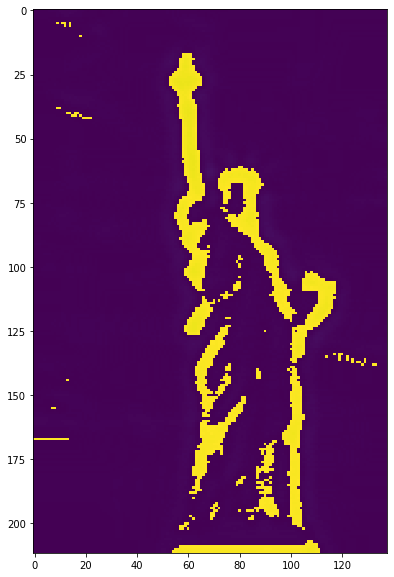

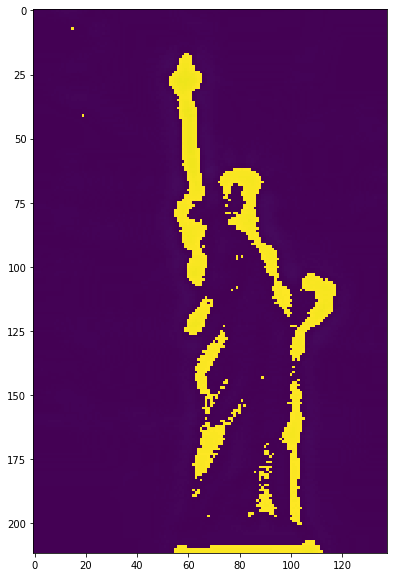

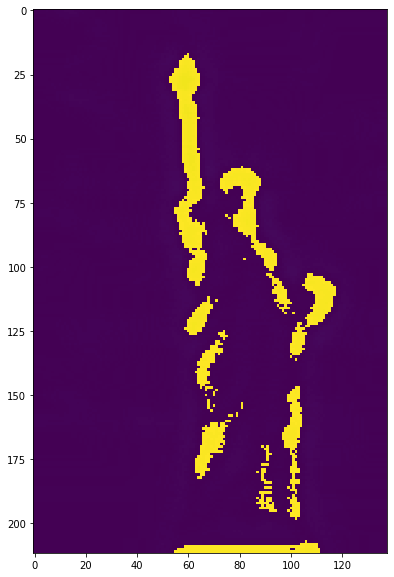

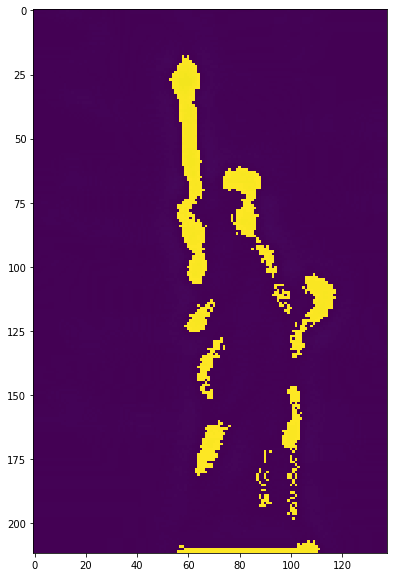

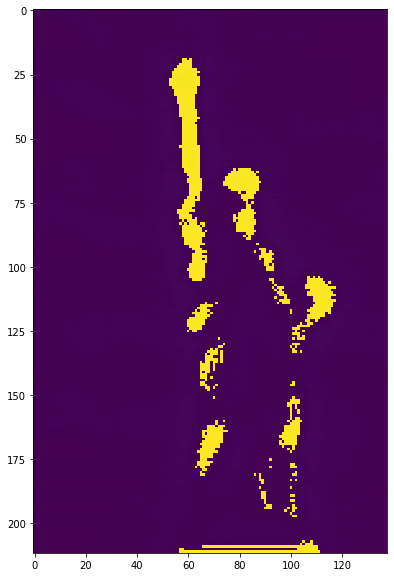

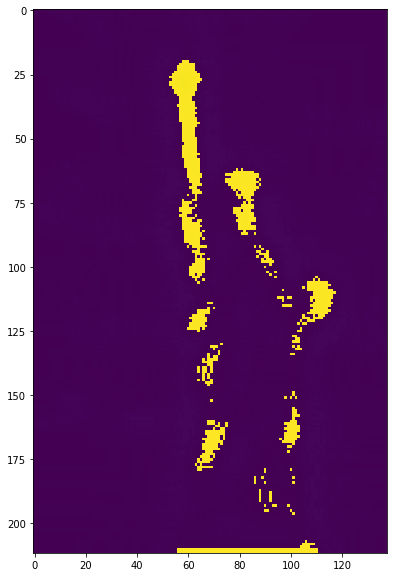

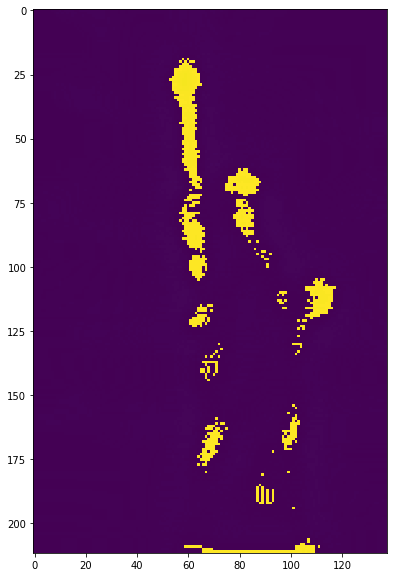

In [100]:
def create_octaves(img, sigma, num_octaves):
    
    gaussian_octaves = {}
    DoG_octaves = {}
    copy = img
    for k in np.arange(num_octaves)+1:
        gaussian_octaves[k] = []
        for i in range(9):
            gaussian_octaves[k].append(copy)
            copy = scipy.ndimage.gaussian_filter(copy, sigma=sigma)

        copy = zoom(copy, 0.5)
    
    for k in np.arange(num_octaves)+1:
        DoG_octaves[k] = []
        for i in np.arange(8):
            DoG_octaves[k].append(gaussian_octaves[k][i] - gaussian_octaves[k][i+1])

        
    return DoG_octaves

octaves = create_octaves(lady, 1.5,2)

for key in octaves.keys():
    for i in range(8):
        img = octaves[key][i]
        plt.figure(figsize=((15,10)))
        plt.imshow(img)
        plt.show()

In [89]:
def find_interest_points(octave):
    interest_points = {}
    m,n = octave[0].shape
    for i in np.arange(6)+1:
        previous_layer = octave[i-1]
        current_layer = octave[i]
        next_layer = octave[i+1]
    

(425, 275)

In [103]:
np.arange(6)+1

array([1, 2, 3, 4, 5, 6])